In [37]:
import pandas as pd
import numpy as np

In [40]:
hotels = pd.read_csv('hotels.csv')
hotels['hotel_address'].head(20)

0     Stratton Street Mayfair Westminster Borough Lo...
1     130 134 Southampton Row Camden London WC1B 5AF...
2      151 bis Rue de Rennes 6th arr 75006 Paris France
3     216 Avenue Jean Jaures 19th arr 75019 Paris Fr...
4             Molenwerf 1 1014 AG Amsterdam Netherlands
5                    Via Mecenate 121 20138 Milan Italy
6     97 Cromwell Road Kensington and Chelsea London...
7     Josefsgasse 4 6 08 Josefstadt 1080 Vienna Austria
8     190 Queen s Gate Kensington and Chelsea London...
9     Holland Park Avenue Kensington and Chelsea Lon...
10            Molenwerf 1 1014 AG Amsterdam Netherlands
11    34 44 Barkston Gardens Kensington and Chelsea ...
12    16 Sumner Place Kensington and Chelsea London ...
13    97 Cromwell Road Kensington and Chelsea London...
14     Putget 68 Sarri St Gervasi 08023 Barcelona Spain
15             Caspe 103 Eixample 08013 Barcelona Spain
16    1 Kings Cross Road Islington London WC1X 9HX U...
17    Wrights Lane Kensington and Chelsea London

In [22]:
hotels['hotel_name'].nunique()
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
hotels['review_date'].max()

Timestamp('2017-08-03 00:00:00')

In [7]:
def rev_func(str_tags):
    str_tags = str_tags[2:-2]
    list_tags = str_tags.strip().split(' \', \' ')
    return list_tags
hotels['tags_n'] = hotels['tags'].apply(rev_func)
hotels['tags_n'].head(2)

0    [Leisure trip, Couple, Studio Suite, Stayed 2 ...
1    [Business trip, Couple, Standard Double Room, ...
Name: tags_n, dtype: object

In [18]:
hotels = hotels.explode('tags_n')
#len(hotels['tags_n'].unique())
tags_list = hotels['tags_n'].tolist()

def most_frequent(tags_list):
    return max(set(tags_list), key = tags_list.count)
print(most_frequent(tags_list))

Leisure trip


In [28]:
hotels['tags'] = hotels['tags'].apply(lambda x: x[3:-3].split(' \', \' '))

In [35]:
def get_stay(x):
    for tag in x:
        words = tag.split()
        if words[0] =='Stayed':
            return int(words[1])
    return np.NaN

hotels['stay'] = hotels['tags'].apply(get_stay)
hotels['stay'].mode()
#hotels['stay'].fillna(1, inplace=True)

0    1.0
Name: stay, dtype: float64

In [70]:
hotels = hotels.drop(['days_since_review', 'tags', 'positive_review', 'negative_review', 
                      'reviewer_nationality', 'hotel_address', 'review_date', 'hotel_name'], axis = 1)

In [71]:
hotels = hotels.fillna(value=0, inplace=False)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 9 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   review_total_negative_word_counts           386803 non-null  int64  
 3   total_number_of_reviews                     386803 non-null  int64  
 4   review_total_positive_word_counts           386803 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 6   reviewer_score                              386803 non-null  float64
 7   lat                                         386803 non-null  float64
 8   lng                                         386803 non-null  float64
dtypes: float64(4), int64(5)
memory usage: 26.6 MB


РАЗДЕЛЕНИЕ

In [72]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

In [73]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [74]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

ОЦЕНКА ЗНАЧИМОСТИ ПЕРЕМЕННЫХ

In [79]:
# непрерывные признаки
num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts', 'review_total_positive_word_counts',
            'additional_number_of_scoring', 'total_number_of_reviews_reviewer_has_given']

# категориальные признаки
cat_cols = ['average_score', 'lat']

Для оценки значимости категориальных переменных будем использовать изученный нами непараметрический тест хи-квадрат, реализованный в библиотеке sklearn.feature_selection.chi2. Метод возвращает массив значений хи-квадрат и p-value для каждого признака. Используем только значения хи-квадрат и выведем их на графике:

<AxesSubplot: >

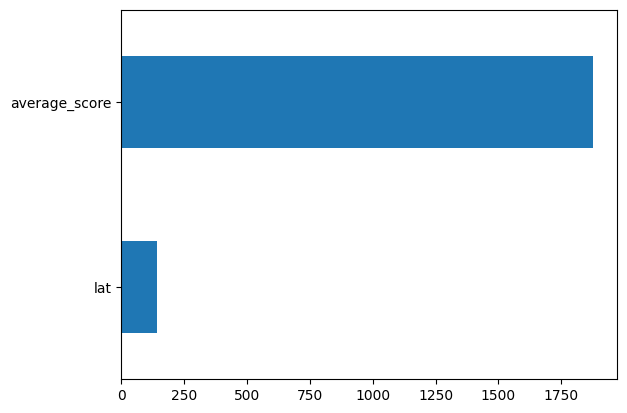

In [80]:
y=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Для оценки значимости непрерывных переменных будем использовать функцию f_classif из библиотеки sklearn. В основе метода оценки значимости переменных лежит изученный вами в юнитах по статистике анализ (ANOVA). Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t).

<AxesSubplot: >

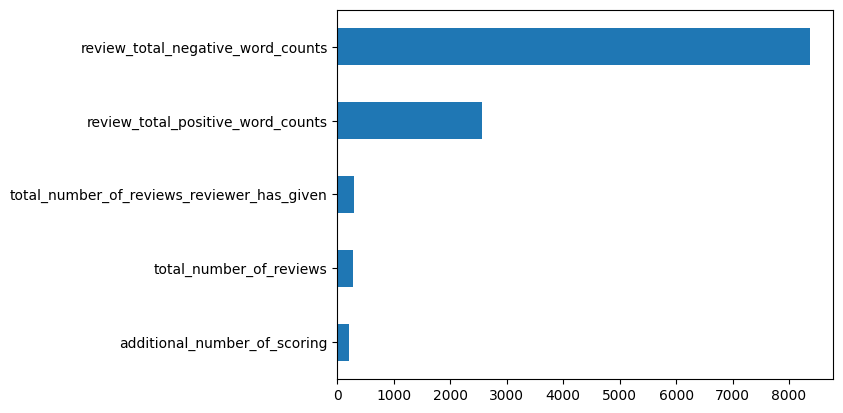

In [77]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

ОБУЧЕНИЕ

In [42]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [43]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.14142743044561526


Небольшой бонус:


In [ ]:
# # убираем признаки которые еще не успели обработать, 
# # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
# object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
# hotels.drop(object_columns, axis = 1, inplace=True)

# # заполняем пропуски самым простым способом
# hotels = hotels.fillna(0)

In [ ]:
# Запускаем кодирование для наиболее частых тегов. Граница для
# наиболее часто берется 5% от размера набора данных.

boundary = hotels.shape[0] * 0.05  # 5% граница
c = Counter(tag for row in hotels['tags'] for tag in row)
frequent_tags_count = dict(filter(lambda x: x[1] > boundary, c.items()))
print('Наиболее часто встречающиеся теги и их количество:')
frequent_tags_count

In [ ]:
# Получение списка наиболее часто встречающихся тегов. Теги "stay" исключены

frequent_tags = list(dict(filter(lambda x: 
    x[1]>boundary and x[0].split()[0]!='Stayed', 
    frequent_tags_count.items())).keys())
frequent_tags

# Быстрое кодирование для частых тегов.

for tag in frequent_tags:
    hotels[tag] = hotels['tags'].apply(lambda x: 1 if tag in x else 0)

В приложении ссылки на ноутбуки в kaggel и github.
https://www.kaggle.com/code/lightarumrumiantseva/project-3-bookingcom-svetlana-rumyantseva/edit/run/130853040
https://github.com/lightarum/my_first_project/tree/main/SkillFactory/project_3
Достигнутое MAPE на каггле 12.83916
В процессе работы первый вариант MAPE был немного больше, после доп. удаления столбцов с сильной корреляцией MAPE был улучшен (вторая попытка, в приложении). Третья попытка была нормализовать данные, но в данном случае MAPE почти не изменилось от первоначального.